In [1]:
%reset -f
%clear

In [2]:
### Importing Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import quantecon as qe
import collections
import math
from matplotlib.pyplot import cm
import time

### Steady-State Distributions

----


In [8]:
#####################################################################################
# Goal: 
#    This part of codes aims to solve the steady-state produtivity distribution
#    and the value functions The numerial results provide the illustration of 
#    models/ mechanism
#
# Structure:
#    Part I : Set the values of parameters
#    Part II: Given the value of lambda, calculate the steady-state distribution
#              The method is the discretization. 
#    Part III : Given the steady-state distribution, and the guess of wage and lambda, 
#              calculate the value fucntions.
#    Part IV  : Use the entry conditions to pin down the value of wage and lambda
#    Part V : Calculate the number of markets, N
#
#####################################################################################


def utility(c,l, beta, a):
    
    '''
        Given the consumption c and labor supply l, give out the temporal utility
        Inputs: 
            beta: discount rate, parameter, data-type: scaler
            a: elasticity of labor supply, parameter, data-type: scaler
            c: consumption, variable, data-type: n * 1 vector
            l: labor, variable, data-type: n * 1 vector
        Outputs:
            utility: data-type: n * 1 vector
    '''

    return beta*math.log(c) - a * l

def prof_1(z, w, theta, a):
    
    '''
        Given the productivity, z, and the wage, w, give out the profit
        Inputs:
            theta: elasticity of substitution between goods, parameter, data-type: scaler
            z: productivity, variable, data-type: scaler
            w: wage, variable, data-type: scaler
        Outputs:
            profit: data-type: scaler
    '''

    Y = w/a
    profit = np.ones(len(z))
    for i in range(len(z)):
        profit[i] = Y * (theta/(theta-1)*w/z[i])**(1-theta)/theta
    
    return profit

def prof_2(z, z_, w, theta, a):
    
    '''
        Given the own productivity, z, compititor's productivity z_, and the wage, w, 
        give out the profit
        Inputs:
            theta: elasticity of substitution between goods, parameter, data-type: scaler
            z,z_: productivity, variable, data-type: scaler
            w: wage, variable, data-type: scaler
        Outputs:
            profit: data-type: scaler
    '''
    
    profit = np.zeros([len(z),len(z_)])
    for i in range(len(z)):
        for j in range(len(z_)):
            # pin down the market share, s
            s = ((1-theta)*z_[j] + theta * z[i])/(z[i] + z_[j])    
            
            # calculate the profit:
            Y = w/a
            profit[i,j] = Y * s**2/theta * (theta/(theta-s)*w/z[i])**(1-theta)
    
    return profit


###################### Part I: Paramters, values ################################### 

# Parameters
beta = 0.95
a = 0.9
theta = 1.3
delta = 0.05

# productivity grid
rho = 0.9
num_state = 50

# Assume H(z) and h(z) is CDF and PDF of uniform distribution
h = np.ones(num_state)*1/num_state
h = np.matrix(h)

# generate the productivity grid
MC = qe.markov.approximation.tauchen(rho, sigma_u=1, b = 0, m = 4, n = num_state)
z_grid = np.exp(MC.state_values)


################## Part II: Steady-State Distribution ##############################

# Calculate the Steady-state productivity distribution function of monopoly 
# markets, G_M(z)
def GM_dist(P, h, lambdax, num_state):
    
    '''
        Given the value lambdax, gives out the steady-state productivity distribution 
        of monopoly markets GM, and the corresponding GDF gM
        
        Inputs:
            P: Transition matrix of Markov chain
            h: PDF of entrants' produtivity distribution
            lambdax: proportion of duopoly markets
        Outputs:
            GM, gM: CDF and PDF of productivity distribution
    
    '''
    
    '''
        The Motion of Distribtuion Function G_M(z) follows:
            
            g_M(z') = delta/(1-lambda)h(z') 
                            + [1-delta-lambda*delta/(1-lambda)] Gamma(z',z)g_M(z)
        
            g_M(z): the PDF of productivity distribution in Monopoly markets
            h(z): the PDF of productivity distribution of Entrants
            Gamma(z',z): transition matrix of productivity Markov process
    
        In equilibrium, g_M(z') = g_M(z), 
        so the solution is:
    
            g_M(z) = (delta/(1-lambda)) * 
                    {I - [1-delta-lambda*delta/(1-lambda)] Gamma(z',z)}^{-1} h(z)
                
            I: identity matrix, dimension is the number of productitity states
        
    '''

    Gamma = np.mat(P)

    ## Calculate the steady-state CDF G_M
    eye = np.identity(num_state)

    B = eye - (1-delta-lambdax*delta/(1-lambdax))*Gamma.T
    gM = (delta)/(1-lambdax)*np.linalg.inv(B).dot(h.T)

    GM = np.cumsum(gM).T
    
    return gM, GM


# Calculate the Steady-state joint productivity distribution function of 
# duopoly markets, G_D(z)
def GD_dist(P, g, h, lambdax, num_state):
    
    '''
        Given the value lambdax, gives out the steady-state marginal productivity 
        distribution of duopoly markets GD, and the corresponding GDF gD
        
        Inputs:
            P: Tranasition matrix of Markov chain
            h: PDF of entrants' produtivity distribution
            lambdax: proportion of duopoly markets
            g: steadt-state productivity distribution of monopoly markets, PDF
        Outputs:
            gJ, GD, gD: joint PDF; CDF and PDF of marginal productivity distribution
    
    '''
    
    '''
        The Motion of Distribtuion Function G_D(z) follows:
            
           gD(z')*gD(z_')^T = (1-delta) [(Gamma^T * gD(z) )*(Gamma^T * gD(z_))^T] + 
                     (delta/2) [(Gamma^T * gM(z)) * h(z_')^T] +
                     (delta/2) [h(z') * (Gamma^T * gM(z_))^T]
        
            gM(z): the PDF of productivity distribution in Monopoly markets
            h(z): the PDF of productivity distribution of Entrants
            Gamma: transition matrix of productivity Markov process
            gD(z): marginal distribution of productivity, PDF
    
        In equilibrium, gD(z') = gD(z), 
        so the solution is:
    
            vec(gJ) = [I - (1-delta)*(Gamma^T # Gamma^T )^T]^(-1) *
                      (delta/2)* [(h # Gamma^T) + (Gamma^T # h)] vec(gM)..........(1)
                
            I: identity matrix, dimension is square of the number of productitity states
            #: Kronecker product
            vec: vectorization of a matrix
    '''
    
    start = time.time()
    
    # generate the necessary PDFs
    Gamma = np.mat(P)
    
    # construct the first line of Equation (1)
    n = int(num_state*num_state)
    L = np.identity(n) - (1-delta) * np.kron(Gamma.T, Gamma.T)
    
    # construct the second line of Equation (1)
    R1 = np.dot(np.kron(h.T, Gamma.T), g) 
    R2 = np.dot(np.kron(Gamma.T, h.T), g)
    R = (R1+R2).T
    
    # calculate the vec(gJ) and reshape it into the matrix form
    gJ = delta/2 * np.linalg.inv(L).dot(R)
    gJ = gJ.reshape((num_state, num_state), order = 'F' )
    
    # Calculate the Marginal PDF, CDF
    gD = np.sum(gJ, axis = 1)
    GD = np.cumsum(gD).T
    
    end = time.time()
    print('time spent:', end - start)

    return gJ, gD, GD


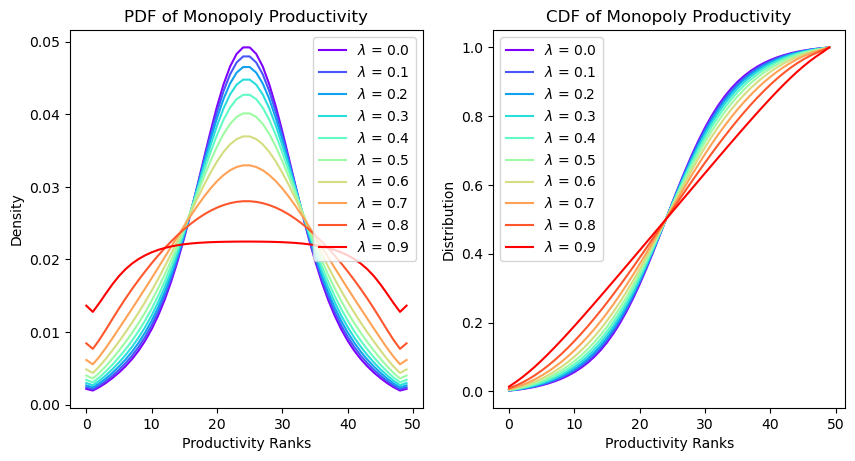

In [48]:
Lambdax = np.linspace(0,0.9,10)
gM_store = np.zeros([num_state,10])
GM_store = np.zeros([num_state,10])

for i in range(10):
    gM, GM = GM_dist(MC.P, h, Lambdax[i],num_state)
    gM_store[:,i] = np.asarray(gM)[:,0]
    GM_store[:,i] = np.asarray(GM)[:,0]

state = np.linspace(0,num_state-1, num_state)

def plot_result(text):
    color = cm.rainbow(np.linspace(0, 1, 10))
    
    fig = plt.figure(figsize = [10,5], dpi = 100)
    
    ax1 = plt.subplot(1,2,1)    
    plt.xlabel('Productivity Ranks')
    plt.ylabel('Density')
    plt.title('PDF of Monopoly Productivity')
    
    ax2 = plt.subplot(1,2,2)   
    plt.xlabel('Productivity Ranks')
    plt.ylabel('Distribution')
    plt.title('CDF of Monopoly Productivity')

    
    for i in range(10):
        ax1.plot(state, gM_store[:,i], color = color[i], label = text[i])
        ax1.legend()
        ax2.plot(state, GM_store[:,i], color = color[i], label = text[i])
        ax2.legend()
    plt.show()
    
text = ['$\lambda$ = '+ str(round(x,2)) for x in Lambdax[range(10)]]
plot_result(text)

time spent: 1.0553042888641357
time spent: 1.1822431087493896
time spent: 0.8746531009674072
time spent: 0.8850762844085693
time spent: 0.9056165218353271
time spent: 0.9094150066375732
time spent: 1.001894235610962
time spent: 1.3898682594299316
time spent: 0.8499879837036133
time spent: 1.0988874435424805


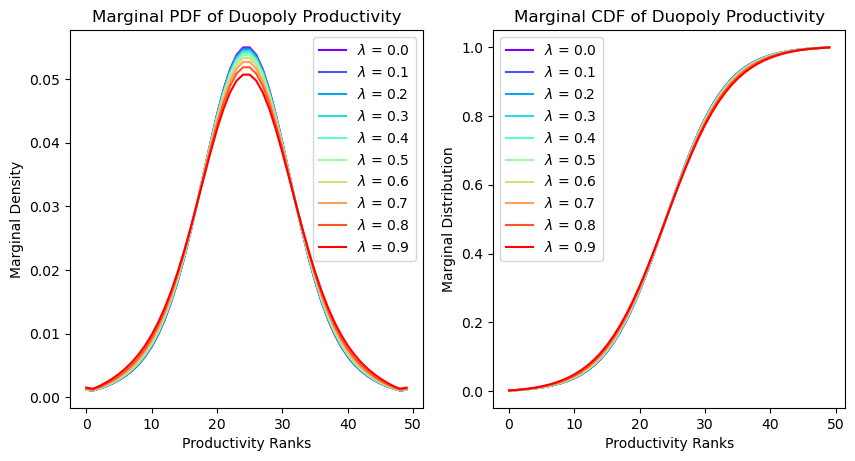

In [49]:
gJ_store = np.zeros([num_state, num_state, 10])
gD_store = np.zeros([num_state,10])
GD_store = np.zeros([num_state,10])

for i in range(10):
    gJ, gD, GD = GD_dist(MC.P, gM_store[:,i], h, Lambdax[i],50)
    gJ_store[:,:,i] = np.asarray(gJ)
    gD_store[:,i] = np.asarray(gD)[:,0]
    GD_store[:,i] = np.asarray(GD)[:,0]

state = np.linspace(0,num_state-1, num_state)

def plot_result(text):
    color = cm.rainbow(np.linspace(0, 1, 10))
    
    fig = plt.figure(figsize = [10,5], dpi = 100)
    
    ax1 = plt.subplot(1,2,1)    
    plt.xlabel('Productivity Ranks')
    plt.ylabel('Marginal Density')
    plt.title('Marginal PDF of Duopoly Productivity')
    
    ax2 = plt.subplot(1,2,2)   
    plt.xlabel('Productivity Ranks')
    plt.ylabel('Marginal Distribution')
    plt.title('Marginal CDF of Duopoly Productivity')

    
    for i in range(10):
        ax1.plot(state, gD_store[:,i], color = color[i], label = text[i])
        ax1.legend()
        ax2.plot(state, GD_store[:,i], color = color[i], label = text[i])
        ax2.legend()
    plt.show()
    
text = ['$\lambda$ = '+ str(round(x,2)) for x in Lambdax[range(10)]]
plot_result(text)

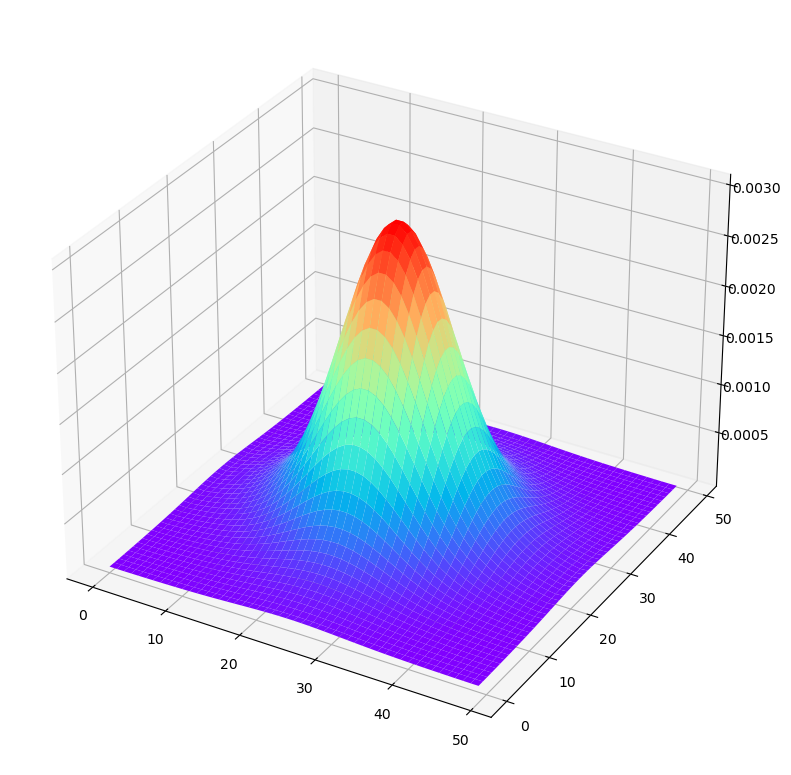

In [6]:
size = gJ_store[:,:,2].shape
X = np.arange(0, size[0], 1)
Y = np.arange(0, size[1], 1)
X, Y = np.meshgrid(X,Y)

fig = plt.figure(figsize = [10,10], dpi = 100)
ax = plt.gca(projection = '3d')
ax.plot_surface(X, Y, gJ_store[:,:,2],cmap='rainbow')
plt.show()

### Value Function Iteration

----

In [5]:
###################### Part III: Value Functions ################################### 
# Define the RHS of Bellman Equations
def Mixed_V2(V2M, V2D, V20, z_grid):
    
    '''
        Goal: the RHS of value functional equations have a weighted avergage
                values of V2. This function aims to combine different parts 
                of V2M, V2D, and V20 to prepare the weighted V2
                The base of mixture is the value of z
    '''
    
    Mixed_V2 = np.mat(np.zeros([num_state, num_state]))
    
    for i in range(len(z_grid)):
        upper = (theta)/(theta-1) * z_grid[i]
        lower = (theta-1)/theta * z_grid[i]
        if upper > z_grid[-1] and lower > z_grid[-1]:
            Mixed_V2[i] = V2M[i]
        elif upper > z_grid[-1] and z_grid[0] < lower < z_grid[-1]:
            a = int(np.where(z_grid < lower)[0][-1])
            Mixed_V2[i,0:a] = V2M[i,0:a]
            Mixed_V2[i,a:] = V2D[i,a:]
        elif upper > z_grid[-1] and lower < z_grid[0]:
            Mixed_V2[i] = V2D[i]
        elif upper < z_grid[0]:
            Mixed_V2[i] = V20[i]
        elif upper < z_grid[-1] and lower < z_grid[0]:
            b = int(np.where(z_grid < upper)[0][-1])
            Mixed_V2[i,0:b] = V2D[i,0:b]
            Mixed_V2[i,b:] = V20[i,b:]
        else:
            a = int(np.where(z_grid < lower)[0][-1])
            b = int(np.where(z_grid < upper)[0][-1])
            Mixed_V2[i,0:a] = V2M[i,0:a]
            Mixed_V2[i,a:b] = V2D[i,a:b]
            Mixed_V2[i,b:] = V20[i,b:]
    
    return Mixed_V2
      
    

In [6]:
# Value function iteration given values of w and lambda
def VF(w,lambdax):
    V1_pri = V1 = np.mat(np.zeros([num_state])).T
    V2M_pri = V2M = np.mat(np.zeros([num_state, num_state]))
    V2D_pri = V2D = np.mat(np.zeros([num_state, num_state]))
    V20_pri = V20 = np.mat(np.zeros([num_state, num_state]))
    
    tor = 1
    for itera in range(1500):
        if tor > 1e-8:
            start = time.time()
            V2M_pri = np.repeat(prof_1(z_grid, w, theta, a),num_state).reshape(num_state,num_state) + beta * (1-delta) * np.dot(MC.P,np.dot(MC.P, Mixed_V2(V2M, V2D, V20, z_grid).T))
            V2D_pri = prof_2(z_grid, z_grid, w, theta, a) + beta * (1-delta) * np.dot(MC.P,np.dot(MC.P, Mixed_V2(V2M, V2D, V20, z_grid).T))
            V20_pri = beta * (1-delta) * np.dot(MC.P,np.dot(MC.P, Mixed_V2(V2M, V2D, V20, z_grid).T))
            V1_pri = np.mat(prof_1(z_grid, w, theta, a)).T + \
                                            beta * (1-delta-lambdax*delta/(1-lambdax)) * np.dot(MC.P,V1) + \
                                            beta * lambdax*delta/(1-lambdax) * np.dot(MC.P,np.dot(h, Mixed_V2(V2M, V2D, V20, z_grid).T).T)
        
            tor1 = np.linalg.norm(V1_pri - V1)
            tor2 = np.linalg.norm(V2M_pri - V2M)
            tor3 = np.linalg.norm(V2D_pri - V2D)
            tor4 = np.linalg.norm(V20_pri - V20)
            tor = np.max((tor1, tor2, tor3, tor4))
        
            V1 = V1_pri
            V2M = V2M_pri
            V2D = V2D_pri
            V20 = V20_pri
            
            end = time.time()
        
            print(itera, tor, start - end)
    return [V1, V2M, V2D, V20]


In [9]:
V1, V2M, V2D, V20 = VF(w=0.7, lambdax = 0.5)

0 106.05602273472978 -0.024682283401489258
1 91.43541567858314 -0.019431352615356445
2 54.391085037810655 -0.02602076530456543
3 50.20319888148051 -0.011968612670898438
4 32.82161205820786 -0.015784740447998047
5 30.17232572933436 -0.02012014389038086
6 21.072286216679753 -0.02024984359741211
7 19.276367268395223 -0.019629955291748047
8 14.18227964520438 -0.014820098876953125
9 12.910629263474986 -0.020145416259765625
10 9.916192393700188 -0.01512908935546875
11 8.99117249977486 -0.019887208938598633
12 7.160978555456733 -0.025217294692993164
13 6.475375985571981 -0.019605398178100586
14 5.317143224676236 -0.020319223403930664
15 4.800670053834254 -0.02016592025756836
16 4.041924615618246 -0.014704465866088867
17 3.6467423217570465 -0.02306818962097168
18 3.1316323148113927 -0.014250516891479492
19 2.8248235241911264 -0.00906062126159668
20 2.4623549640046174 -0.02349400520324707
21 2.221135287982299 -0.025729656219482422
22 1.9573478184215485 -0.019153833389282227
23 1.765762889144142

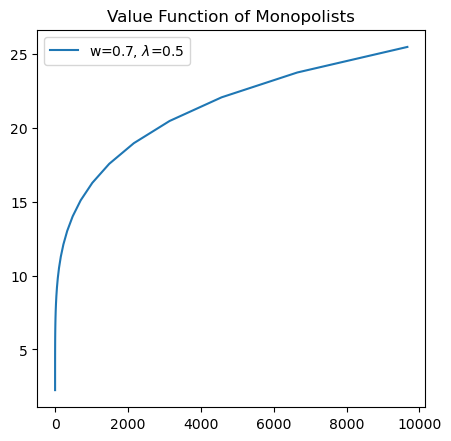

In [10]:
fig = plt.figure(figsize = [5,5], dpi = 100)
ax = plt.subplot(1,1,1)
ax.plot(z_grid, V1, label = 'w=0.7, $\lambda$=0.5')
plt.legend()
plt.title('Value Function of Monopolists')
plt.show()

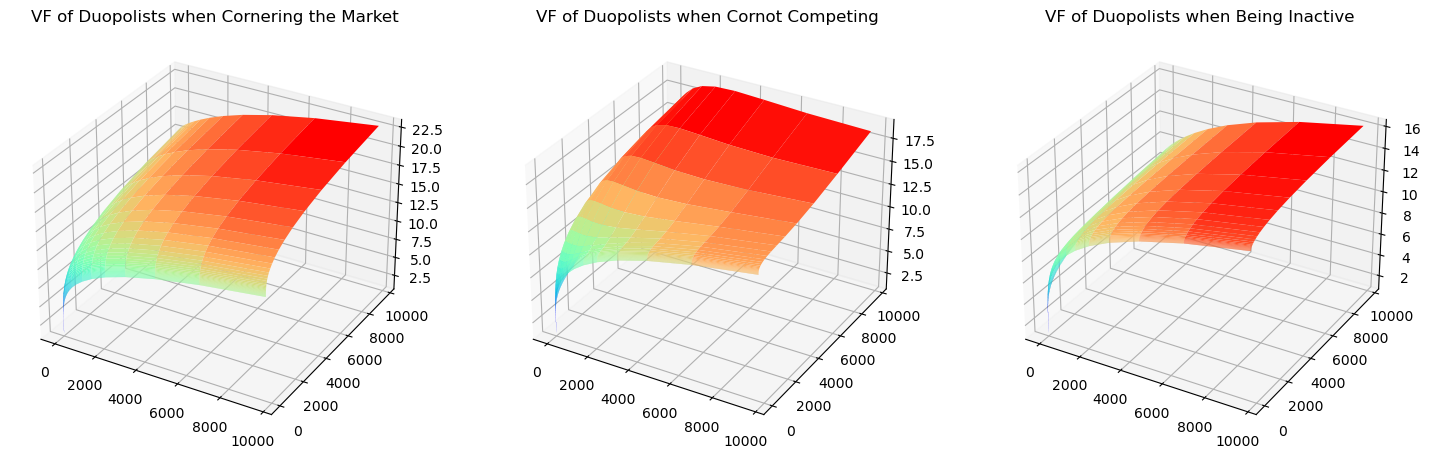

In [11]:
fig = plt.figure(figsize = [18,6], dpi = 100)
x_grid, y_grid = np.meshgrid(z_grid, z_grid)

ax1 = plt.subplot(1,3,1, projection = '3d')
ax1.plot_surface(x_grid, y_grid, V2M, label = 'w=0.7, $\lambda$=0.5', cmap = 'rainbow')
plt.title('VF of Duopolists when Cornering the Market')

ax2 = plt.subplot(1,3,2, projection = '3d')
ax2.plot_surface(x_grid, y_grid, V2D, label = 'w=0.7, $\lambda$=0.5', cmap = 'rainbow')
plt.title('VF of Duopolists when Cornot Competing')

ax3 = plt.subplot(1,3,3, projection = '3d')
ax3.plot_surface(x_grid, y_grid, V20, label = 'w=0.7, $\lambda$=0.5', cmap = 'rainbow')
plt.title('VF of Duopolists when Being Inactive')

plt.show()

### Searching w-$\lambda$ space to meet Entry Conditions

----


In [76]:
###################### Part IV: Equilibrium values of w and lambda ################################### 
## set the value of entry consts CM, CD
CM = 15
CD = 10

'''
     larger w ---> larger V1, V2M, V2D, no effects on V20
     larger lambda ---> smaller V1, no effects on V2M, V2D, V20
     larger lambda ---> GD: fatter tails
              
'''

'''
    The next process and graph show the nearly-upper and nearly-lower bounds of 
    expected values of monopolists and duopolists given wage.
'''

## guess the intitial value w and lambda
w1 = np.arange(0.01,2,0.1)
Ave_V1 = np.zeros([len(w1),2])
Ave_V2 = np.zeros([len(w1),2])

gM_up, GM_up = GM_dist(MC.P, h, 0.95 ,num_state)
gJ_up, gD_up, GD_up = GD_dist(MC.P, np.asarray(gM_up)[:,0], h, 0.95, num_state)

gM_lo, GM_lo = GM_dist(MC.P, h, 0.01 ,num_state)
gJ_lo, gD_lo, GD_lo = GD_dist(MC.P, np.asarray(gM_lo)[:,0], h, 0.01, num_state)

start0 = time.time()
for i in range(len(w1)):
    V1_up, V2M_up, V2D_up, V20_up = VF(w1[i], 0.95)
    V1_lo, V2M_lo, V2D_lo, V20_lo = VF(w1[i], 0.01)
    Ave_V1[i,0] = np.dot(h,V1_up)
    Ave_V1[i,1] = np.dot(h,V1_lo)
    Ave_V2[i,1] = np.dot(h ,np.dot(gD_lo.T, Mixed_V2(V2M_lo, V2D_lo, V20_lo, z_grid).T).T)
    Ave_V2[i,0] = np.dot(h ,np.dot(gD_up.T, Mixed_V2(V2M_up, V2D_up, V20_up, z_grid).T).T)
end0 = time.time()
end0 - start0



time spent: 1.3753893375396729
time spent: 1.5232045650482178
0 5.419593439237651 -0.04760265350341797
1 4.672462403809747 -0.05485939979553223
2 2.779451463697083 -0.04686450958251953
3 2.5654453209823926 -0.06283044815063477
4 1.6772248174984317 -0.07879114151000977
5 1.541843021760744 -0.0624241828918457
6 1.0768197900019674 -0.056839942932128906
7 0.9850461188935362 -0.07879757881164551
8 0.7247319646413029 -0.07332634925842285
9 0.6597490632641436 -0.06282830238342285
10 0.5067296496073227 -0.06781744956970215
11 0.4594599932595521 -0.07333540916442871
12 0.3659348276216851 -0.04388618469238281
13 0.3308996915317182 -0.02392888069152832
14 0.27171257032728363 -0.017952680587768555
15 0.24532015492209158 -0.017951488494873047
16 0.2065473281370229 -0.03291201591491699
17 0.18635302599474862 -0.033908843994140625
18 0.1600302699442887 -0.024933576583862305
19 0.14435196270750866 -0.026964664459228516
20 0.12582937266441224 -0.01695537567138672
21 0.11350274999956346 -0.0209450721740

263.72327494621277

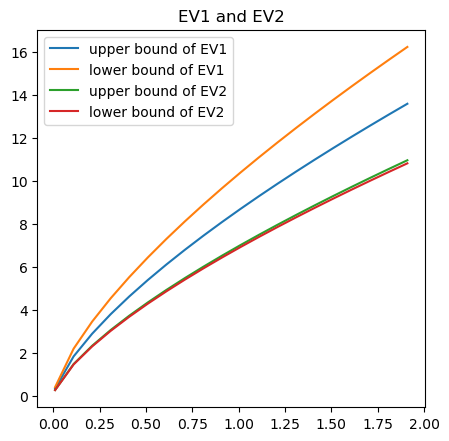

In [78]:
fig = plt.figure(figsize = [5,5], dpi = 100)
ax = plt.subplot(1,1,1)
ax.plot(w1, Ave_V1[:,0], label = 'upper bound of EV1')
ax.plot(w1, Ave_V1[:,1], label = 'lower bound of EV1')
ax.plot(w1, Ave_V2[:,0], label = 'upper bound of EV2')
ax.plot(w1, Ave_V2[:,1], label = 'lower bound of EV2')
plt.legend()
plt.title('EV1 and EV2')
plt.show()

In [43]:
Ave_V1_up = np.dot(h,V1_up)
Ave_V1_lo = np.dot(h,V1_lo)
Ave_V1_up, Ave_V1_lo

(matrix([[6.72814442]]), matrix([[8.03620086]]))

In [61]:
gM_up, GM_up = GM_dist(MC.P, h, 0.95 ,num_state)
gJ_up, gD_up, GD_up = GD_dist(MC.P, np.asarray(gM_up)[:,0], h, 0.95, num_state)

gM_lo, GM_lo = GM_dist(MC.P, h, 0.01 ,num_state)
gJ_lo, gD_lo, GD_lo = GD_dist(MC.P, np.asarray(gM_lo)[:,0], h, 0.01, num_state)



time spent: 0.8754408359527588
time spent: 0.9156033992767334


In [73]:
np.dot(h ,np.dot(gD_lo.T, Mixed_V2(V2M_lo, V2D_lo, V20_lo, z_grid).T).T)
np.dot(h ,np.dot(gD_up.T, Mixed_V2(V2M_up, V2D_up, V20_up, z_grid).T).T)

matrix([[5.42728694]])